# ARIMA - Autoregressive (AR) Integrated (I) Moving Averages (MA)
We have to find values for
- p (AR term; #AR lags)
- d (order of integration; #differencing needed to remove trend & seasonality)
- q (MA term; #MA lags)

In [2]:
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
# Retrieve timeseries data
df = pd.read_csv('SPX.csv') 
df.drop(["Open", "High", "Low", "Volume"], axis=1, inplace = True)
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y') 
df.set_index('Date', inplace=True)

df = df[6500:]

display(df.head())
print(df.shape)

,Close
Date,
2006-02-01,1282.46
2006-02-02,1270.84
2006-02-03,1264.03
2006-02-06,1265.02
2006-02-07,1254.78


(4144, 1)


## 1. Check if timeseries is stationary. Else, make it stationary
### 1. a) Visualise data & rolling statistics

In [4]:
# Get rolling mean & standard deviation
WINDOW_SIZE = math.ceil(len(df)/5)
df['rolmean'] = df['Close'].rolling(window=WINDOW_SIZE).mean()
df['rolstd'] = df['Close'].rolling(window=WINDOW_SIZE).std()

In [16]:
fig = px.line(df, y=["Close", "rolmean", "rolstd"], title="Timeseries")
fig.show()

### 1. b) Dickey-Fuller test - check for stationarity

In [17]:
# H0: timeseries isn't stationary
# H1: timeseries is stationary

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(df):
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')

    dfout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
    for key, value in dftest[4].items():
        dfout['Critical value (%s)'%key] = value
    print(dfout)

dickey_fuller(df['Close'])

Result of Dickey-Fuller Test:
Test Statistic             0.282101
p-value                    0.976508
#Lags used                27.000000
#Observations used      4116.000000
Critical value (1%)       -3.431940
Critical value (5%)       -2.862242
Critical value (10%)      -2.567144
dtype: float64


Since p-value > 0.05, we don't reject null hypothesis. The timeseries isn't stationary.

### 1. c) Differencing - to make the timeseries stationary & find d

In [5]:
# 1st differencing
df['1st diff'] = df['Close'].diff()

df['1st diff rolmean'] = df['1st diff'].rolling(window=WINDOW_SIZE).mean()
df['1st diff rolstd'] = df['1st diff'].rolling(window=WINDOW_SIZE).std()

In [19]:
fig = px.line(df, y=["1st diff", "1st diff rolmean", "1st diff rolstd"], title="Timeseries after 1st Differencing")
fig.show()

### 1. d) Perform Dickey Fuller test again after differencing

In [20]:
dickey_fuller(df['1st diff'].dropna())

Result of Dickey-Fuller Test:
Test Statistic         -1.308387e+01
p-value                 1.846910e-24
#Lags used              2.600000e+01
#Observations used      4.116000e+03
Critical value (1%)    -3.431940e+00
Critical value (5%)    -2.862242e+00
Critical value (10%)   -2.567144e+00
dtype: float64


Since p-value < 0.05, we now reject null hypothesis. The timeseries is stationary. <br>
So we stop differencing.

## 2. Plot correlations
### 2. a) Autocorrelation - to find/affirm <b>d</b>, <b>p</b>

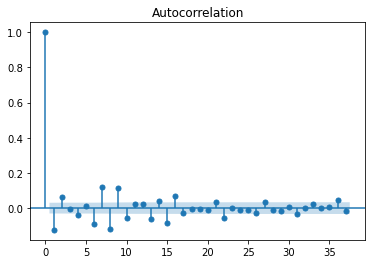

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['1st diff'].dropna());


The autocorrelation <b>falls to zero or negative very early</b> in the series. <br>
This is a sign that the series is close to being over-differenced, so we should <b>stop further differencing</b>. <br>
Hence, we fix <b>d = 1</b>. <br><br>

We can also drive <b>p</b> value from this plot, by looking at <b>where the exponential decrease ends</b>.<br>
Based on this plot, so we'll fix <b>p = 2</b>.

### 2. b) Partial Autocorrelation - to find <b>p</b>

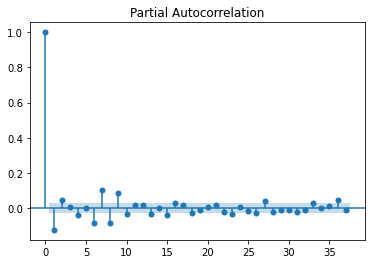

In [22]:
plot_pacf(df['1st diff'].dropna());

The plot <b>"shuts down" after lag 2</b>, as partial autocorrelation <b>close approaches the significance limit</b> (light blue region at y=0). <br>
So we'll fix <b>q = 2</b>.
## 3. The ARIMA model (based on p,d,q values)
### 3. a) Construct model

In [6]:
# p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# train test split
train_size = int(len(df) * 0.9)
train = df['Close'][:train_size]
test = df['Close'][train_size:]

In [8]:
#model = sm.tsa.statespace.SARIMAX(df['Close'],order=(2, 1, 2),seasonal_order=(2,1,2,365))
model = ARIMA(train, order=(2,1,2)) #(q,d,p)
model_fit = model.fit()
model_fit.summary()

c:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3729
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -16925.779
Date:                Sat, 23 Jul 2022   AIC                          33861.558
Time:                        11:19:08   BIC                          33892.676
Sample:                             0   HQIC                         33872.628
                               - 3729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2025      0.090     -2.257      0.024      -0.378      -0.027
ar.L2         -0.1726      0.054     -3.206      0.001      -0.278      -0.067
ma.L1          0.0396      0.091      0.433      0.665      -0.140       0.219
ma.L2          0.2585      0.042      6.123      0.000       0.176       0.341
sigma2       514.2405      3.661    140.470      0.000     507.065     521.416
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             86634.59
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.62   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the 2nd table, the values under 'coef' are the weights of p,d,q <br>
Moreover, all 'P>|z|' values are < 0.05, meaning all terms are statistically significant, which is good!

### 3. b) Make & visualise predictions

In [10]:
df['predictions'] = np.nan
df['predictions'][train_size:] = model_fit.predict(start=train_size, end=len(df)-1, dynamic=True)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df['Close'][train_size:], df['predictions'][train_size:])
# can compare mse to naive forecast's
fig = px.line(df, y=["Close", "predictions"], title=f"ARIMA Forecast with MSE = {mse}")
fig.show()

c:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
